In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

from pprint import pprint
import sys

import flax
import flax.linen as nn
from flax.training import train_state
import jax
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt
import numpy as np
import optax
import seaborn as sns

from neurovae import load_mnist, plot_digits, DNNVAE

sns.set_theme(context="paper", style='darkgrid', rc={"axes.facecolor": "0.96"})
fontsize = "x-large"
params = {"font.family": "serif",
          "font.sans-serif": ["Computer Modern"],
          "axes.labelsize": fontsize,
          "legend.fontsize": fontsize,
          "xtick.labelsize": fontsize,
          "ytick.labelsize": fontsize,
          "legend.handlelength": 2
          }
plt.rcParams.update(params)

In [2]:
@jax.vmap
def kl_divergence(mean, logvar):
    return -0.5 * jnp.sum(1 + logvar - jnp.square(mean) - jnp.exp(logvar))


@jax.vmap
def binary_cross_entropy_with_logits(logits, labels):
    logits = nn.log_sigmoid(logits)
    return -jnp.sum(labels * logits + (1.0 - labels) * jnp.log(-jnp.expm1(logits)))


def compute_metrics(recon_x, x, mean, logvar):
    bce_loss = binary_cross_entropy_with_logits(recon_x, x).mean()
    kld_loss = kl_divergence(mean, logvar).mean()
    return {"bce": bce_loss, "kld": kld_loss, "loss": bce_loss + kld_loss}


def train_step(state, batch, z_rng, hidden_dims, latent_dim):
    def loss_fn(params):
        recon_x, mean, logvar = DNNVAE(hidden_dims, latent_dim).apply({"params": params}, batch, z_rng)

        bce_loss = binary_cross_entropy_with_logits(recon_x, batch).mean()
        kld_loss = kl_divergence(mean, logvar).mean()
        loss = bce_loss + kld_loss
        return loss

    grads = jax.grad(loss_fn)(state.params)
    return state.apply_gradients(grads=grads)


def eval_f(params, images, z, z_rng, hidden_dims, latent_dim):
    def eval_model(vae):
        recon_images, mean, logvar = vae(images, z_rng)
        comparison = jnp.concatenate(
            [
                images[:8].reshape(-1, 28, 28, 1),
                recon_images[:8].reshape(-1, 28, 28, 1),
            ]
        )

        generate_images = vae.generate(z)
        generate_images = generate_images.reshape(-1, 28, 28, 1)
        metrics = compute_metrics(recon_images, images, mean, logvar)
        return metrics, comparison, generate_images

    return nn.apply(eval_model, DNNVAE(hidden_dims, latent_dim))({"params": params})

In [3]:
learning_rate = 0.001
hidden_dims = (500, 150)
latent_dim = 20
batch_size = 64
num_epochs = 30
num_img_px = 784

rng = random.key(0)
rng, key = random.split(rng)

batches, ds_test = load_mnist(
    batch_size=batch_size,
    drop_remainder=True,
    select_digits=[0, 1, 2, 3],
    as_supervised=False,
    binarized=True,
    shuffle=True,
    shuffle_seed=42,
)

jax.device_put(ds_test)

Array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [4]:
init_data = jnp.ones((batch_size, num_img_px), jnp.float32)
params = DNNVAE(hidden_dims, latent_dim).init(key, init_data, rng)["params"]

In [5]:
state = train_state.TrainState.create(
    apply_fn=DNNVAE(hidden_dims, latent_dim).apply,
    params=params,
    tx=optax.adam(learning_rate),
)

rng, z_key, eval_rng = random.split(rng, 3)
z = random.normal(z_key, (batch_size, latent_dim))

In [6]:
for epoch in range(num_epochs):
    for batch in batches:
        rng, key = random.split(rng)
        state = train_step(state, batch, key, hidden_dims, latent_dim)

    metrics, comparison, sample = eval_f(state.params, ds_test, z, eval_rng, hidden_dims, latent_dim)
    print(f"epoch: {epoch + 1}, loss: {metrics['loss']:.4f}, BCE: {metrics['bce']:.4f}, KLD: {metrics['kld']:.4f}")

epoch: 1, loss: 109.2766, BCE: 88.1466, KLD: 21.1300
epoch: 2, loss: 96.5543, BCE: 73.6386, KLD: 22.9157
epoch: 3, loss: 91.9392, BCE: 68.4723, KLD: 23.4669
epoch: 4, loss: 88.3993, BCE: 64.0333, KLD: 24.3660
epoch: 5, loss: 85.8466, BCE: 60.4813, KLD: 25.3653
epoch: 6, loss: 84.9155, BCE: 60.3826, KLD: 24.5330
epoch: 7, loss: 83.0457, BCE: 58.3631, KLD: 24.6826
epoch: 8, loss: 82.8409, BCE: 57.0935, KLD: 25.7474
epoch: 9, loss: 81.9585, BCE: 55.8747, KLD: 26.0838
epoch: 10, loss: 82.7665, BCE: 56.9168, KLD: 25.8497
epoch: 11, loss: 81.8435, BCE: 56.1945, KLD: 25.6491
epoch: 12, loss: 80.9776, BCE: 55.4900, KLD: 25.4877
epoch: 13, loss: 80.8734, BCE: 54.8145, KLD: 26.0589
epoch: 14, loss: 80.8735, BCE: 54.8466, KLD: 26.0270
epoch: 15, loss: 80.2138, BCE: 54.1778, KLD: 26.0360
epoch: 16, loss: 79.7099, BCE: 53.3422, KLD: 26.3678
epoch: 17, loss: 79.9611, BCE: 53.4799, KLD: 26.4811
epoch: 18, loss: 79.9125, BCE: 53.9324, KLD: 25.9801
epoch: 19, loss: 79.5550, BCE: 53.2581, KLD: 26.2968
e

In [8]:
org_imgs = comparison[:8]
recon_imgs = nn.sigmoid(comparison[8:])

(<Figure size 500x500 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: >, <Axes: >]], dtype=object))

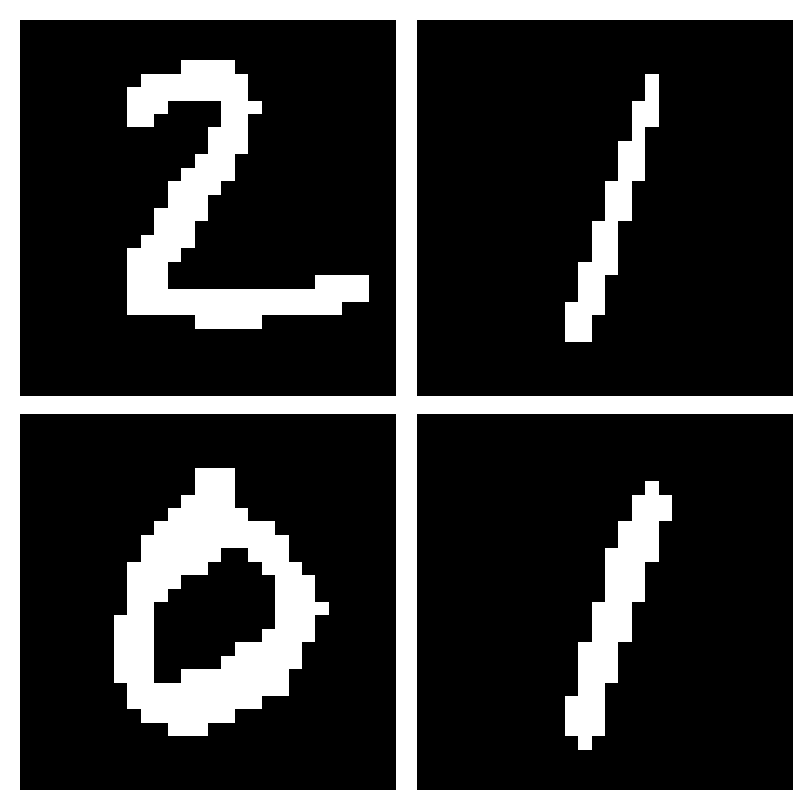

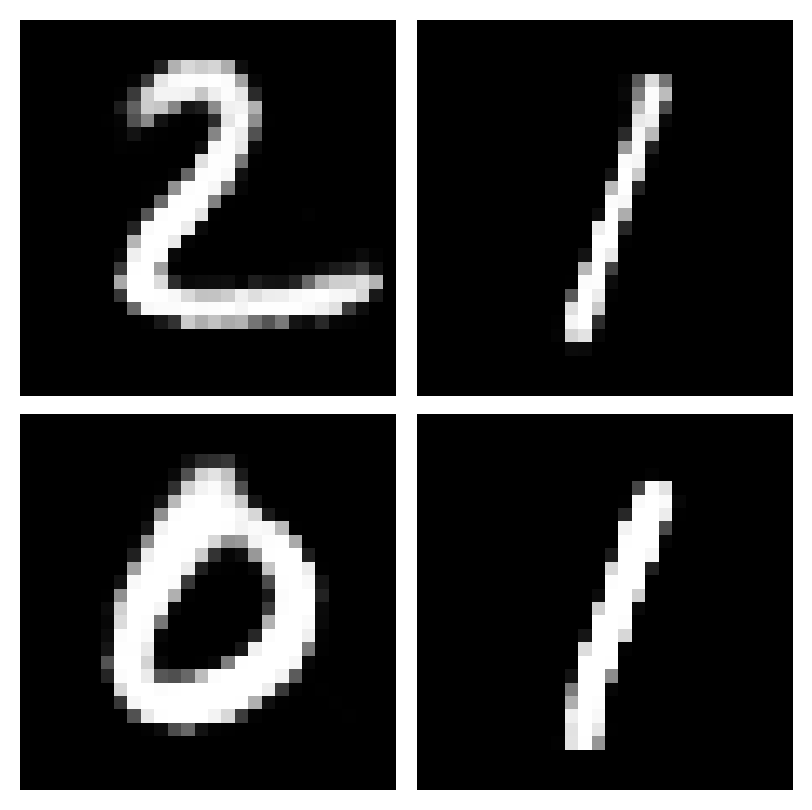

In [9]:
plot_digits(org_imgs[:4])
plot_digits(recon_imgs[:4])

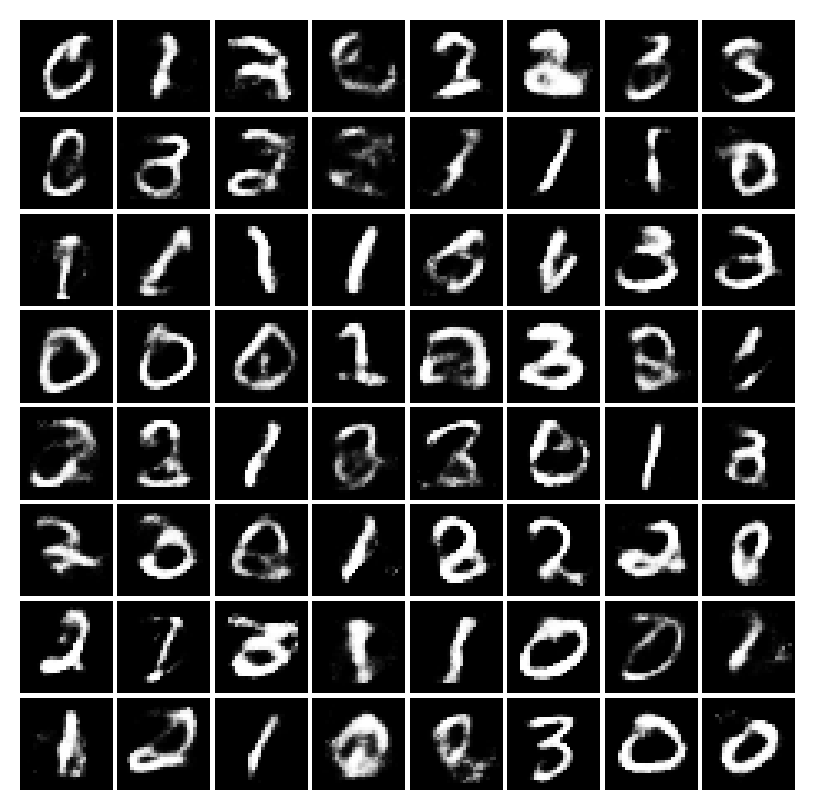

In [11]:
plot_digits(sample)